# А/В тестирование 

В нашем распоряжении данные по проведению А/В тестирования:
+ 9 гипотез с оценками Reach, Impact, Confidence и Effort;
+ выгрузка покупок пользователей с указанием группы тестирования;
+ количество пользователей для каждой группы тестирования за каждый день наблюдения.

**Цель исследования:**
проверить гипотезы по увеличению выручки интернет-магазина и сформулировать рекомендации для отдела маркетинга.

**Задачи исследования:**

1. Приоритизировать гипотезы.
2. Проанализировать результаты A/B-тестирования.


**Ход исследования**

Данные о гипотезаах с оценками Reach, Impact, Confidence и Effort я получу из CSV-файла `'/datasets/hypothesis.csv'`. Данные о покупках пользователей  с указанием группы тестирования получу из CSV-файла `'/datasets/orders.csv'`, а данные о количестве пользователей для каждой группы тестирования за каждый день наблюдения из CSV-файла `'/datasets/visitors.csv'`. О качество данных ничего неизвестно. Поэтому перед тем, как приступать к целям исследования, понадобится обзор данных.

Я проверю данные на ошибки. Затем на этапе предобработки я поищу возможность исправить все ошибки данных, которые могут привести к искажению конечного результата. Далее применю необходимые функции, создам нужные датасеты и приступлю к проведению исследовательского анализа.

Таким образом, моё исследование пройдёт в  5 этапов:
1. [Обзор данных.](#section_1)
2. [Предобработка данных.](#section_2)
3. [Приоритизация гипотез.](#section_3)
4. [Анализ А/В теста.](#section_4)
5. [Написание общего вывода.](#section_5)

### Обзор данных
<a id='section_1'></a>

Импортируем библиотеки для дальнейшей работы с ними.

In [2]:
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np
from scipy import stats as stats
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

#### Импорт данных из csv-файла в датафрейм и сохранение в переменных.

Загружаем данные о гипотезах, заказах и покупателях. Сохраняем данные в переменных `hypothesis`, `orders` и `visitors`.

In [2]:
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv'),
    )
    
except:
    hypothesis, orders, visitors = (
        pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv', sep='\t'),
        pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', sep='\t'),
        pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', sep='\t'),
    )

#### Ознакомление с данными и их описание.

*Посмотрим датафрейм `hypothesis`.*

In [3]:
pd.options.display.max_colwidth = 130
hypothesis.head(20)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


*Hypothesis* — краткое описание гипотезы;\
*Reach* — охват пользователей по 10-балльной шкале;\
*Impact* — влияние на пользователей по 10-балльной шкале;\
*Confidence* — уверенность в гипотезе по 10-балльной шкале;\
*Efforts* — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


9 гипотез с четырьми числовыми оценками от 1 до 10 включительно. Всё верно. Но названия столбцов нужно привести к общепринятому виду. Вернёмся к этому позже.

*Посмотрим датафрейм `orders`.*

In [5]:
orders.head(20)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


*transactionId* — идентификатор заказа;\
*visitorId* — идентификатор пользователя, совершившего заказ;\
*date* — дата, когда был совершён заказ;\
*revenue* — выручка заказа;\
*group* — группа A/B-теста, в которую попал заказ.

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Более 1000 заказов. Названия столбцов нужно привести к простому для понимания общепринятому виду, а тип данных столбца `date` изменить. Вернёмся к этому позже.

*Посмотрим датафрейм `visitors`.*

In [7]:
visitors.head(20)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


*date* — дата;\
*group* — группа A/B-теста;\
*visitors* — количество пользователей в указанную дату в указанной группе A/B-теста.

In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


62 наблюдения, т.е. 1 месяц наблюдений по 2 группам. Тип данных столбца `date` нужно позже изменить. 

> На первый взгляд необходимы следующие шаги: в двух датасетах переименовать столбцы и во всех датасетах поменять формат данных. Рассмотрим данные ещё детальнее.

### Предобработка данных
<a id='section_2'></a>

#### Переименование столбцов.

Приводим названия колонок к общепринятому стилю.

In [9]:
hypothesis.columns = [x.lower() for x in hypothesis.columns.values]

In [10]:
orders = orders.rename(columns= {'transactionId': 'order_id',\
                                 'visitorId': 'user_id'})

Столбцы переименованы.

#### Изучение дубликатов.

Проверим датафреймы на наличие явных дубликатов.

In [11]:
hypothesis.duplicated().sum()

0

In [12]:
orders.duplicated().sum()

0

In [13]:
visitors.duplicated().sum()

0

Ни в одном из датафреймов нет дубликатов. 

#### Поиск пропущенных значений и анализ причин пропусков данных. Изменение типов данных

**Рассмотрим датафрейм `hypothesis`.**

In [14]:
pd.DataFrame(round(hypothesis.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
hypothesis,0.000000
reach,0.000000
impact,0.000000
confidence,0.000000
efforts,0.000000


В датафрейме `hypothesis` пропусков нет.

При обзоре датафрейма отметили, что оценки идут от 1 до 10 включительно. Значит ошибок в датасете нет, и он готов к анализу.

**Рассмотрим датафрейм `orders`.**

In [15]:
pd.DataFrame(round(orders.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
order_id,0.000000
user_id,0.000000
date,0.000000
revenue,0.000000
group,0.000000


В датафрейме `orders` пропусков нет.

Рассмотрим сколько пользователей в каждой группе.

In [16]:
users_a = orders[orders['group'] == 'A']

users_a['user_id'].count()

557

In [17]:
users_b = orders[orders['group'] == 'B']

users_b['user_id'].count()

640

В группах неравное количество пользователей. Группы не очень хорошо сбалансированы по числу пользователей. Но разное количество может объясняться разной конверсией (пришло на сайт одинаковое количество, а сделало заказы - разное).

In [18]:
users_ab = users_a.merge(users_b, on='user_id', how='inner')
double_users = list(users_ab['user_id'].unique())
len(double_users)

58

58 пользователей есть в обоих группах. Это не позволит провести корректное сравнение групп. Удалим таких пользователей из групп.

In [19]:
mask = orders['user_id'].isin(double_users)

orders = orders[~mask]

Изменим тип данных столбца `date`.

In [20]:
orders['date'] = pd.to_datetime(orders['date'])

Проверим датасет на наличие ошибок.

In [21]:
orders['date'].sort_values()

103    2019-08-01
148    2019-08-01
147    2019-08-01
97     2019-08-01
145    2019-08-01
          ...    
957    2019-08-31
930    2019-08-31
996    2019-08-31
1022   2019-08-31
997    2019-08-31
Name: date, Length: 1016, dtype: datetime64[ns]

Датасет содержит данные за август 2019 года. Ошибочных данных нет.

In [22]:
orders['revenue'].sort_values()

459          50
584          50
756          50
933          60
404          70
         ...   
743       67990
744       86620
1136      92550
1196     202740
425     1294500
Name: revenue, Length: 1016, dtype: int64

Разброс выручки достаточно большой.

In [23]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

Есть только 2 группы, т.к.  есть 2 варианта - "до" изменений и "после". Всё верно.

**Рассмотрим датафрейм `visitors`.**

In [24]:
pd.DataFrame(round(visitors.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
date,0.000000
group,0.000000
visitors,0.000000


В датафрейме `visitors` пропусков нет.

Изменим тип данных столбца `date`.

In [25]:
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим датасет на наличие ошибок.

In [26]:
# временной диапазон

visitors['date'].sort_values()

0    2019-08-01
31   2019-08-01
1    2019-08-02
32   2019-08-02
2    2019-08-03
        ...    
28   2019-08-29
60   2019-08-30
29   2019-08-30
30   2019-08-31
61   2019-08-31
Name: date, Length: 62, dtype: datetime64[ns]

Поле содержит данные за август 2019 года. Ошибочных данных нет.

In [27]:
# названия групп

visitors['group'].unique()

array(['A', 'B'], dtype=object)

Есть только 2 группы - всё верно.

In [28]:
visitors['visitors'].sort_values()

15    361
40    369
54    378
23    395
9     406
     ... 
44    746
12    748
4     756
43    769
34    770
Name: visitors, Length: 62, dtype: int64

62 наблюдения. От 361 до 770 пользователей в день.

В датасете `visitors` ошибок нет. Он готов к анализу.

> Качество входных данных хорошее: нет ярковыраженных аномальных значений, дубликатов и пропусков.

### Приоритизация гипотез
<a id='section_3'></a>

Применяем фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [29]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)

display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending = False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по ICE с индексами 8, 0, 7, 6 и 2. 

In [30]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']

display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по RICE в порядке убывания приоритетности:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.
5. Запустить акцию, дающую скидку на товар в день рождения.

> При приоритизации ICE и RICE пятёрка перспективных гипотез одинаковая, только разная приоритетность. Поменялась приоритетность из-за оценки охвата пользователей в числителе. Чем выше оценка охвата пользователей, тем выше RICE.

### Анализ A/B-теста
<a id='section_4'></a>

#### Выручка

Построим график кумулятивной выручки по группам.

In [31]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'order_id' : 'nunique', 'user_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Проверим, корректно ли создан датафрейм cumulativeData. Посмотрим, совпадают ли минимальная и максимальная даты в этом датафрейме и в исходных данных:

In [32]:
cumulativeData['date'].min()

Timestamp('2019-08-01 00:00:00')

In [33]:
cumulativeData['date'].max()

Timestamp('2019-08-31 00:00:00')

Даты совпадают, значит датафрейм создан корректно.

Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

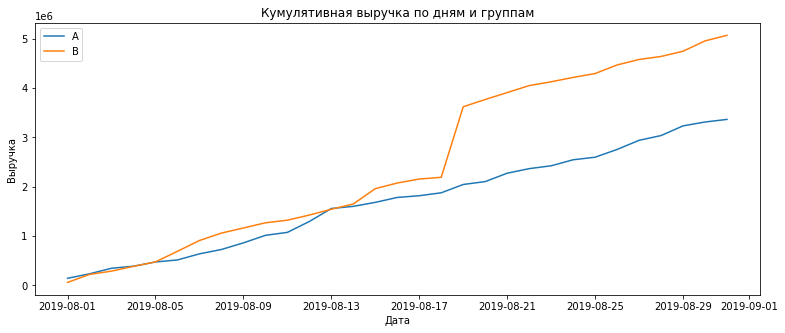

In [34]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(13, 5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручка по дням и группам')
plt.legend()
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. 
Однако график выручки группы В в одной точке резко растёт. Это может сигнализировать о всплеске числа заказов либо о появлении очень дорогих заказов в выборке.

#### Средний чек

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

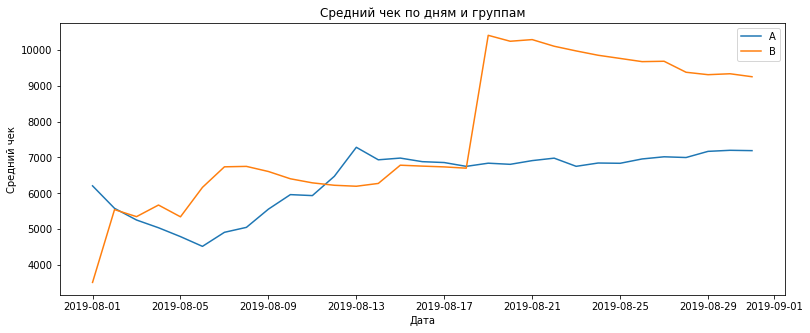

In [35]:
plt.figure(figsize=(13, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('Средний чек по дням и группам')
plt.legend() 

Средний чек тоже становится равномерным ближе к концу теста: близок к установлению для группы A и продолжает падать для группы B. 

Возможно, в группу B в начале и в середине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. А в группе В в начале теста, скорее всего, были сильно дешёвые заказы.

#### Относительное изменение среднего чека

Построим график относительного различия для среднего чека. Добавим горизонтальную ось:

Text(0.5, 1.0, 'Относительное изменение среднего чека по дням и группам')

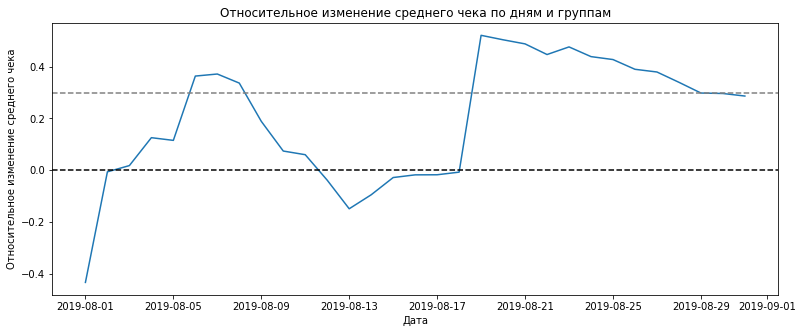

In [36]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(13, 5))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

# добавляем ось на значении 0.3
plt.axhline(y=0.3, color='grey', linestyle='--')



plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего чека')
plt.title('Относительное изменение среднего чека по дням и группам')

В нескольких точках график различия между сегментами резко «скачет». Где-то точно спрятались крупные заказы и выбросы. Найдём их позже.

#### Среднее количество заказов на посетителя по группам

Аналогично проанализируем график кумулятивной конверсии. Зададим масштаб осей и передадим ему минимальное и максимальное значения оси x; минимальное и максимальное значения оси y — `["2019-04-01", '2019-04-23', 0, 0.015]`:

Text(0.5, 1.0, 'Среднее количество заказов на посетителя по группам')

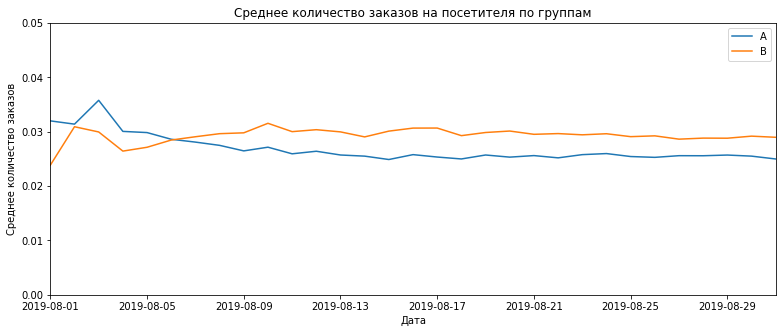

In [37]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(13, 5))
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05])

plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.title('Среднее количество заказов на посетителя по группам')

Группы колебались около одного значения, но затем конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась.

#### Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A

Построим график относительного различия кумулятивных конверсий:

Text(0.5, 1.0, 'Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')

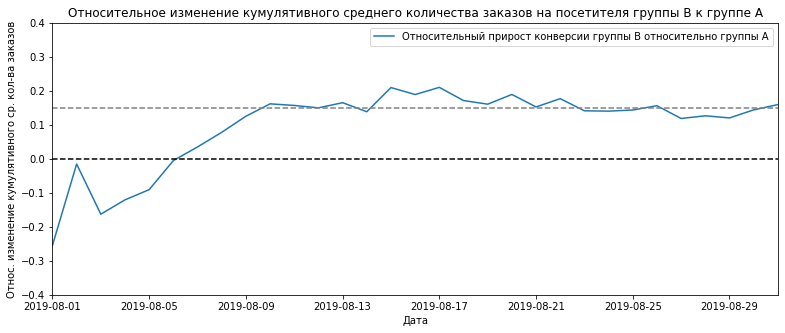

In [38]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(13, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), - 0.4, 0.4])

plt.xlabel('Дата')
plt.ylabel('Относ. изменение кумулятивного ср. кол-ва заказов')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом её конверсия колебалась около значения 0,15. Однозначно можно сделать вывод, что группа B более успешная с точки зрения количества заказов на посетителя.

#### Количество заказов по пользователям

Пользователи, совершившие много заказов, влияют на числитель формулы конверсии. «Обычный» пользователь совершает не больше двух заказов за короткий срок. 

Подсчитаем количество заказов по пользователям и посмотрим на результат:

In [39]:
orders_by_users = (
    orders.groupby('user_id', as_index=False)
    .agg({'order_id': 'nunique'})
)

orders_by_users.columns = ['user_id', 'orders']

orders_by_users.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Построим точечную диаграмму числа заказов на одного пользователя:

Text(0.5, 1.0, 'Количество заказов по пользователям')

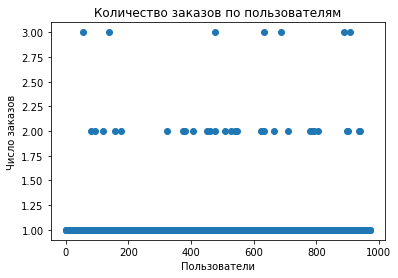

In [40]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])

plt.xlabel('Пользователи')
plt.ylabel('Число заказов')
plt.title('Количество заказов по пользователям')

Явных аномалий в наблюдениях нет. Это хорошо. 2 заказа на пользователя случаются редко, а 3 заказа на пользователя ещё реже. Видимо, интернет-магазин не имеет регулярного спроса.

#### Определение аномального количества заказов на одного пользователя

Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [41]:
print(np.percentile(orders_by_users['orders'], [90, 95, 99])) 

[1. 1. 2.]


Не более 5% пользователей оформляли больше чем 1 заказ. И только 1% пользователей заказывали более одного раза. 

Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

#### Стоимости заказов

Аномально дорогие заказы следует удалять из теста. Оценим стоимости заказов:

Text(0.5, 1.0, 'Стоимости заказов по пользователям')

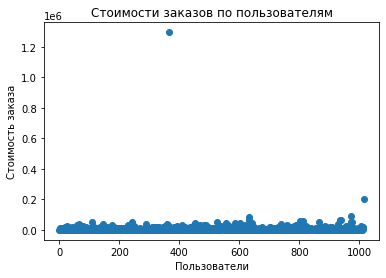

In [42]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.title('Стоимости заказов по пользователям')

Есть один очень дорогой заказ. Сложно определить границу при таком масштабе - рассмотрим точечный график крупнее.

(0.0, 100000.0)

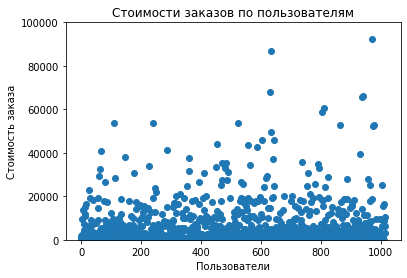

In [43]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.title('Стоимости заказов по пользователям')
plt.ylim(0, 100000)

По графику можно выбрать границу аномальных заказов около 40 000 рублей. 

#### Определение аномальных стоимостей заказов

In [44]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[17990. 26785. 53904.]


Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Если брать во внимание график, то логичнее взять границу в 99% - 53 904 рублей.

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. 

*Нулевая*: различий в среднем количестве заказов между группами нет. 

*Альтернативная*: различия в среднем между группами есть.

In [45]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_a_cummulative']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_b_cummulative']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'order_id', 'user_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'order_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'order_id', 'user_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'order_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_a_cummulative,visitors_b_cummulative
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Создадим переменные `orders_by_users_a` и `orders_by_users_b` со столбцами `['user_id', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [46]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('user_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('user_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders'] 

Объявим новые переменные. В переменных `sample_a` и `sample_b` пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [47]:
sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


print('p-value равен:', "{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('Различие в среднем количестве заказов:', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p-value равен: 0.011
Различие в среднем количестве заказов: 0.160


Вывод: По «сырым» данным различия в среднем числе заказов групп A и B есть. 

Первое число — `p-value = 0.011` меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Однако относительный выигрыш группы B равен 16% — второе число в выводе.

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 

*Нулевая гипотеза*: различий в среднем чеке между группами нет. 

*Альтернативная гипотеза*: различия в среднем чеке между группами есть. 

Найдём относительные различия в среднем чеке между группами:

In [48]:
print('p-value равен:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Различие в среднем чеке заказа:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value равен: 0.829
Различие в среднем чеке заказа: 0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

> Найденные 95-й и 99-й перцентили средних чеков равны 26 785 и 53 904  рублям. 
>
> А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказа на пользователя.

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Узнаем, сколько всего аномальных пользователей атрибутом `shape`.

In [49]:
percentile = np.nanpercentile(orders_by_users_a['orders'], 99)
users_with_many_orders = pd.concat(
    [
        orders_by_users_a.loc[orders_by_users_a['orders'] > percentile, 'user_id'],
        orders_by_users_b.loc[orders_by_users_b['orders'] > percentile, 'user_id']
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 53904]['user_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print('Количество аномальных пользователей:', abnormal_users.shape[0]) 

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
Name: user_id, dtype: int64
Количество аномальных пользователей: 16


16 аномальных пользователей. Незначительный процент относительно общего числа пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [50]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [51]:
print('p-value равен:','{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Различие в среднем количестве заказов:', '{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

p-value равен: 0.007
Различие в среднем количестве заказов: 0.189


Результаты по среднему количеству заказов практически не изменились - разница между группами по среднему количеству заказов всё-таки есть. Произошло ли что-нибудь с результатами по среднему чеку?

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [52]:
print('p-value равен:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['user_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['user_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Различие в среднем чеке заказа:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['user_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['user_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value равен: 0.788
Различие в среднем чеке заказа: -0.032


P-value увеличился, но и разница между сегментами сократилась с 28.7% до -3.2%. Аномалии оказывают влияние на результаты A/B-теста. Средний чек группы В стал немного меньше, чем средний чек группы А.

#### Решение по результатам теста 

Имеющиеся факты:
+ Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;

+ Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

+ График различия среднего количества заказов между группами сообщает, что результаты группы B улучшились и сейчас почти на 30% лучше.

+ График различия среднего чека говорит о том, что результаты группы B лучше группы A и нет значительной тенденции к ухудшению. 

> Исходя из обнаруженных фактов, тест следует остановить и зафиксировать победу группы В. Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент A на самом деле лучше сегмента B — практически нулевая.

### Общий вывод
<a id='section_5'></a>

Был проведен исследовательский анализ с целью проверить гипотезы по увеличению выручки интернет-магазина. Входные данные - 9 гипотез с оценками Reach, Impact, Confidence и Effort; покупки пользователей с указанием группы тестирования с 1 по 31 августа 2019 года; количество пользователей для каждой группы тестирования за каждый день наблюдения. Результаты исследования будут полезны отделу маркетинга для повышения доходов компании.

В результате удалось сделать следующие выводы:

> 1. Пользователи группы В совершают большее количество заказов.
>
> 2. Средний чек пользователей групп А и В одинаковый.
>
> 3. Тест следует остановить и зафиксировать победу группы В.

**Рекомендации для отдела маркетинга:**

В первую очередь реализовать изменения согласно следующим гипотезам:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
3. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.
4. Запустить акцию, дающую скидку на товар в день рождения. 

Порядок перечисления гипотез соответствует их приоритетности.



*Анализ выполнялся согласно следующим этапам:*
1. Обзор данных.
2. Предобработка данных.
3. Приоритизация гипотез.
4. Анализ А/В теста.
5. Написание общего вывода